<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/ConvNeXT/Fine_tune_ConvNeXT_for_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune ConvNeXT for image classification

This notebook was created as part of [this YouTube video](https://youtu.be/Hn1IgPY42Bw).

It illustrates how to fine-tune [ConvNeXT](https://huggingface.co/docs/transformers/model_doc/convnext), a state-of-the-art image classifier by Meta AI, on a custom dataset (in this case, the [EuroSAT](https://github.com/phelber/EuroSAT) dataset). The goal for the model is to classify satellite images into one of 10 possible categories.

Note that this notebook would be the same to fine-tune [any other image classifier](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification) available in the Transformers library.

## Set-up environment

Let's start by installing the required libraries: 🤗 Transformers and 🤗 Datasets.

In [1]:
!pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.3 MB/s eta 0:00:00


## Load dataset

Let's start by loading the data. In this case, we download a zip file from [this Github repository](https://github.com/phelber/EuroSAT). Next we load it as a 🤗 Dataset using one line of code.

In [ ]:
from datasets import load_dataset

# we can load a custom dataset using the "imagefolder" feature
# details: https://huggingface.co/docs/datasets/image_process#imagefolder
# supports far more than just zip files
dataset = load_dataset("imagefolder", data_files="/content/EuroSAT_RGB.zip")

Image classification datasets usually contain 2 things: images and corresponding labels.

In [24]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], id=None)}

Let's visualize the first training example:

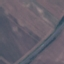

In [25]:
example = dataset["train"][0]
example["image"]

Let's check its corresonding label:

In [26]:
example["label"]

3

Labels are present as integers, but we can turn them into actual class names as follows:

In [21]:
labels = dataset["train"].features["label"].names
print(labels)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [22]:
id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}
print(id2label)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


Looks like the image above is labeled as "highway":

In [23]:
id2label[3]

'Highway'

## Push dataset to the hub

We could push this dataset to the hub so that we can reuse it later:

In [ ]:
# dataset.push_to_hub("nielsr/eurosat-demo")

Reusing is also just one line of code:

In [10]:
from datasets import load_dataset

dataset = load_dataset("nielsr/eurosat-demo")

Generating train split:   0%|          | 0/27000 [00:00<?, ? examples/s]

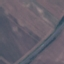

In [12]:
dataset["train"][0]["image"]

## Process data

After we've created a dataset, it's time to prepare it for the model. We first load the image processor corresponding to the pre-trained model which we'll fine-tune.

In [13]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("facebook/convnext-tiny-224")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [14]:
print(image_processor)

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}



During training, we'll define some image transformations like random flipping/cropping in order to create a robust image classifier (as it still needs to predict the right label no matter the orientation or size of the image). This is also known as "image augmentation" as we're augmenting the dataset with all kinds of transformations.

We'll use [Torchvision](https://pytorch.org/vision/stable/transforms.html) here but feel free to use any other library like [Albumentations](https://albumentations.ai/).

In [32]:
from torchvision.transforms import (
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

transform = Compose(
    [
     RandomResizedCrop(image_processor.size["shortest_edge"]),
     RandomHorizontalFlip(),
     ToTensor(),
     normalize
    ]
)

def train_transforms(examples):
  examples["pixel_values"] = [transform(image.convert("RGB")) for image in examples["image"]]

  return examples

In [33]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})

We'll use the [with_transform](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.with_transform) functionality here, which allows to apply the image transformations on-the-fly. This means that when we call this method on our dataset, nothing gets transformed yet.

In [34]:
processed_dataset = dataset.with_transform(train_transforms)

The data only gets transformed when we load it:

In [38]:
processed_dataset["train"][0].keys()

dict_keys(['image', 'label', 'pixel_values'])

## Create PyTorch DataLoader

Next we create a PyTorch [dataloader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) which allows us to get batches of training images and corresponding labels. This is required as neural networks are typically trained on batches rather than on individual items at a time.

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(examples):
  pixel_values = torch.stack([example["pixel_values"] for example in examples])
  labels = torch.tensor([example["label"] for example in examples])

  return {"pixel_values": pixel_values, "labels": labels}

dataloader = DataLoader(processed_dataset["train"], collate_fn=collate_fn, batch_size=4, shuffle=True)

In [ ]:
batch = next(iter(dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


## Define model

Next we'll define our pre-trained model which we'll fine-tune. We replace the image classification head on top (which had 1000 classes as it was pre-trained on ImageNet) and replace it by a randomly initialized one with 10 output neurons (as we have 10 classes).

In [27]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/114M [00:00<?, ?B/s]

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train the model

Here we'll create a basic PyTorch training loop, which goes over the data multiple times. The parameters of the model are updated using backpropagation + stochastic gradient descent.

In [ ]:
from tqdm.notebook import tqdm
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(10):
  print("Epoch:", epoch)
  correct = 0
  total = 0
  for idx, batch in enumerate(tqdm(dataloader)):
    # move batch to GPU
    batch = {k:v.to(device) for k,v in batch.items()}

    optimizer.zero_grad()

    # forward pass
    outputs = model(pixel_values=batch["pixel_values"],
                    labels=batch["labels"])

    loss, logits = outputs.loss, outputs.logits
    loss.backward()
    optimizer.step()

    # metrics
    total += batch["labels"].shape[0]
    predicted = logits.argmax(-1)
    correct += (predicted == batch["labels"]).sum().item()

    accuracy = correct/total

    if idx % 100 == 0:
      print(f"Loss after {idx} steps:", loss.item())
      print(f"Accuracy after {idx} steps:", accuracy)

## Push it to the hub

After (or during) training, one can push the model and image processor to the hub as follows:

In [ ]:
repo_name = "nielsr/convnext-tiny-finetuned-eurosat"

model.push_to_hub(repo_name)
image_processor.push_to_hub(repo_name)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:1004: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/nielsr/convnext-tiny-finetuned-eurosat into local empty directory.


Upload file pytorch_model.bin:   0%|          | 3.34k/106M [00:00<?, ?B/s]

To https://huggingface.co/nielsr/convnext-tiny-finetuned-eurosat
   73b78e0..7a2e6c0  main -> main

To https://huggingface.co/nielsr/convnext-tiny-finetuned-eurosat
   7a2e6c0..4f3580e  main -> main



'https://huggingface.co/nielsr/convnext-tiny-finetuned-eurosat/commit/4f3580e91046d22e9917fd94a2a36e23314e80fd'

## Inference

Let's showcase inference on a new image.

In [40]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

feature_extractor = AutoImageProcessor.from_pretrained("nielsr/convnext-tiny-finetuned-eurosat")
model = AutoModelForImageClassification.from_pretrained("nielsr/convnext-tiny-finetuned-eurosat")

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/111M [00:00<?, ?B/s]

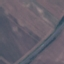

In [48]:
test_example = dataset["train"][0]

test_image = test_example["image"].convert("RGB")
test_image

We can prepare the image for the model using the image processor (assuming it applies the same preprocessing as used during training without the augmentations like random flipping/cropping):

In [49]:
pixel_values = image_processor(test_image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 224, 224])


Next we perform a forward pass to get the logits, which are the unnormalized scores that the model gives to each of the 10 classes:

In [50]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)
  logits = outputs.logits

In [51]:
print(logits.shape)

torch.Size([1, 10])


We can get the predicted class by taking the highest logit value:

In [52]:
predicted_class_idx = logits.argmax(-1).item()
print(model.config.id2label[predicted_class_idx])

Highway


## Pipeline API

Alternatively, one can use the [pipeline](https://huggingface.co/docs/transformers/en/main_classes/pipelines) which abstracts the complexity of what we did above for the user.

In [54]:
from transformers import pipeline

pipe = pipeline(model="nielsr/convnext-tiny-finetuned-eurosat")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [56]:
pipe(test_image)

[{'label': 'Highway', 'score': 0.9996901750564575},
 {'label': 'River', 'score': 0.00015031074872240424},
 {'label': 'AnnualCrop', 'score': 4.87822326249443e-05},
 {'label': 'PermanentCrop', 'score': 3.893173561664298e-05},
 {'label': 'Industrial', 'score': 2.9273147447383963e-05}]